# on improving lowdin with kpm

## imports here

In [1]:
import kwant
import numpy as np
import scipy.linalg as la
import scipy.sparse as sla

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

## prepare random Hamiltonian

In [2]:
def H0_random(nA=4, nB=1000, gap=1, epsilonA=.2, epsilonB=100):
    """Generate random Hamiltonian with quasi-degenerate states."""
    energiesA = epsilonA * np.random.random(nA) - epsilonA / 2
    
    energiesB = epsilonB * np.random.random(nB) - epsilonB / 2
    energiesB = energiesB[np.abs(energiesB) > gap/2]

    energies = np.append(energiesA, energiesB)
    U = kwant.rmt.circular(len(energies))
    
    return U.transpose().conjugate() @ np.diag(energies) @ U


def H1_random(n, v=1):
    return kwant.rmt.gaussian(n, v=v)

In [16]:
alphas = np.linspace(0, .1, 100)
np.random.seed(0)

H0 = H0_random()        # This is H_0
H1 = H1_random(len(H0)) # This is perturbation (H')

H1 = {sympy.sympify('1'): H1}

In [17]:
%%time
ev, evec = la.eigh(H0)

window = (-.25, +.25)
indices = [i for (i, e) in enumerate(ev) if window[0] < e < window[1]]

CPU times: user 1.89 s, sys: 938 ms, total: 2.82 s
Wall time: 853 ms


# 2nd order explicit

In [18]:
from codes.lowdin import second_order_explicit

In [19]:
import sympy

In [20]:
%%time
M2 = second_order_explicit(H1, indices, ev, evec)

CPU times: user 1min 2s, sys: 6.76 s, total: 1min 9s
Wall time: 18.2 s


In [21]:
M2[1, 1]

array([[  4.73591262-1.58341610e-14j,   4.49298354+1.53219972e+01j,
         11.09941547+8.33100822e+00j,   6.6342512 -3.91349775e+00j],
       [  4.49298354-1.53219972e+01j,  -7.6074447 +1.64686892e-14j,
         12.75420406-5.06338852e+00j,  -1.52861888+1.70405836e+00j],
       [ 11.09941547-8.33100822e+00j,  12.75420406+5.06338852e+00j,
         10.01106784-1.36318226e-14j,  -8.22896225-1.95569428e+01j],
       [  6.6342512 +3.91349775e+00j,  -1.52861888-1.70405836e+00j,
         -8.22896225+1.95569428e+01j, -11.84472949+8.46230876e-15j]])

# 2nd order KPM

In [23]:
from codes.lowdin import second_order_kpm

In [24]:
%%time
M2_kpm = second_order_kpm(H0, H1, ev[indices], evec[:, indices], 
                          num_moments=1500)

CPU times: user 14 s, sys: 2.09 s, total: 16.1 s
Wall time: 13.5 s


In [25]:
M2_kpm[1, 1]

array([[  4.85552915 +0.j        ,   4.39555798+15.28320118j,
         11.44747677 +8.45728259j,   6.79190905 -3.85312289j],
       [  4.39555798-15.28320118j,  -7.71223328 +0.j        ,
         12.95227229 -5.02672698j,  -1.57830357 +1.65818185j],
       [ 11.44747677 -8.45728259j,  12.95227229 +5.02672698j,
          9.75602829 +0.j        ,  -8.44467069-19.69761191j],
       [  6.79190905 +3.85312289j,  -1.57830357 -1.65818185j,
         -8.44467069+19.69761191j, -12.07591632 +0.j        ]])

# Convergence

In [27]:
def difference(kpm):
    assert set(M2) == set(kpm)
    output = 0
    for key, val in kpm.items():
        output += la.norm(val - M2[key])
    return output

In [28]:
moments = range(100, 5000, 500)


ds = []
for num_moment in moments:
    print(num_moment)
    kpm = second_order_kpm(
        H0, H1, ev[indices], evec[:, indices], num_moments=num_moment
    )
    ds.append(difference(kpm))
    

100
600
1100
1600
2100
2600
3100
3600
4100
4600


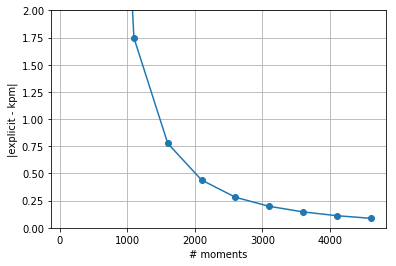

In [29]:
plt.plot(moments, ds, 'o-')
plt.ylabel('|explicit - kpm|')
plt.xlabel('# moments')
plt.ylim(0, 2)
plt.grid()